# import packages and notebook utils

In [5]:
import sys
sys.path.append('../')

from utils.visualize import coord2scatter, plot_edge_index, plot_trend
from data.datasets import load_dataset
from utils.utils import edge_cm
from models import GAE

import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import torch
import json
import os
import sys

device = 'cuda'


def create_log_dict(path: str):
    folder_tree = list(os.walk(os.path.normpath(path)))
    log_dict = dict()
    for root, dirs, files in folder_tree:
        if 'checkpoints' in dirs:
            with open(root + '/args.txt') as json_file:
                log_dict['args'] = json.load(json_file)
            with open(root + '/valid_idx.txt') as json_file:
                log_dict['valid_idx'] = json.load(json_file)
            with open(root + '/test_idx.txt') as json_file:
                log_dict['test_idx'] = json.load(json_file)
        elif 'checkpoints' in root:
            for file in files:
                if 'best' in file:
                    log_dict['ckpt_best'] = root + '\\' + file
                elif 'last' in file:
                    log_dict['ckpt_last'] = root + '\\' + file
    return log_dict

## enter the path of the model you want to test

In [6]:
path = '../log/gae/version_0/'

## load model and datasets

In [11]:
log_dict = create_log_dict(path)
model = GAE.load_from_checkpoint(log_dict['ckpt_best']).to(device)
dataset = load_dataset(
    root='../data/',
    dataset_name=log_dict['args']['dataset'],
    num_graphs=log_dict['args']['num_graphs'],
    min_n_nodes=log_dict['args']['min_n_nodes'],
    max_n_nodes=log_dict['args']['max_n_nodes'],
    device=device
)
valid_set = dataset[log_dict['valid_idx']]
test_set = dataset[log_dict['test_idx']]

Processing...
Done!


# threshold tuning

In [12]:
threshold = model.threshold_tuning(valid_set, n_evaluations=2, n_steps=100)
print('Best threshold: ', threshold)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.90it/s]

Best threshold:  0.7


# test persistency - f1 score

In [13]:
results = model.eval_persistency(test_set, threshold=threshold, n_evaluations=1)

100%|███████████████████████████████████████████| 100001/100001 [01:38<00:00, 1019.92it/s, [step 100000] [f1: 0.98696]]


<IPython.core.display.Javascript object>


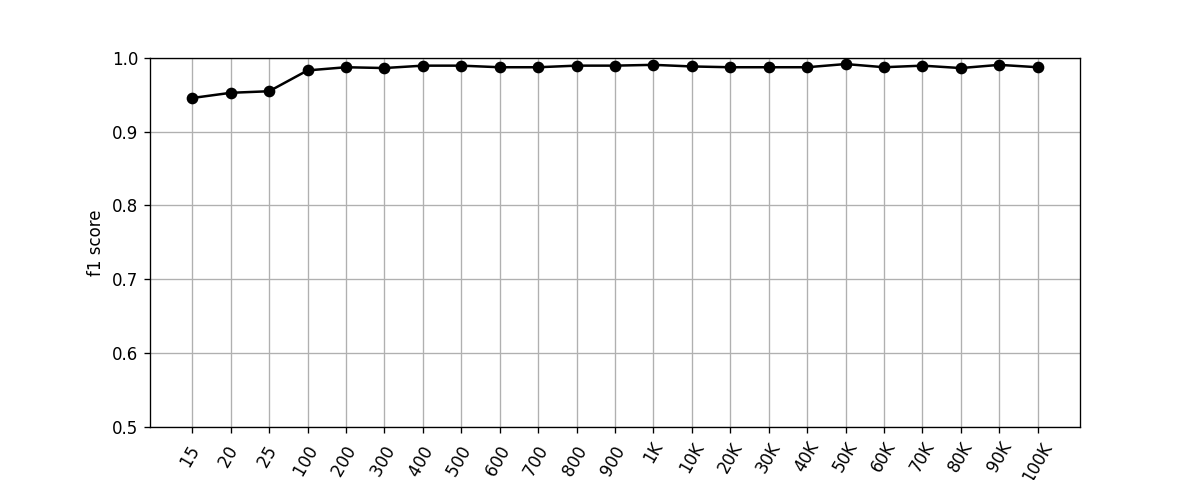

In [14]:
n_steps = results.keys()
f1_avg = [results[n_step]['f1'][0] for n_step in results]
f1_std = [results[n_step]['f1'][1] for n_step in results]
fig, ax = plt.subplots(figsize=(10, 4))
plot_trend(n_steps, f1_avg, f1_std, ylim=[0.5, 1.0], x_label='$t$', y_label='f1 score', ax=ax)

# plot a random test reconstruction - run many times for different results!

In [15]:
pred_edge_index_list = model.eval_dataset(test_set, n_steps=100, threshold=threshold)[1]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]


<IPython.core.display.Javascript object>


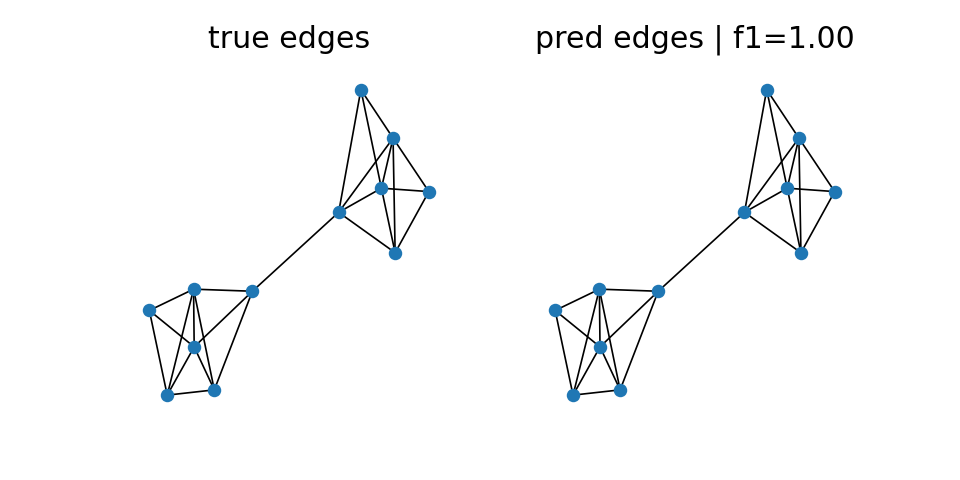

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
idx = np.random.randint(len(test_set))
coord = plot_edge_index(test_set[idx].edge_index, title='true edges', return_coord=True, ax=axs[0], show_ax_values=False, num_nodes=test_set[idx].num_nodes)
f1 = edge_cm(test_set[idx].edge_index, pred_edge_index_list[idx], test_set[idx].num_nodes, return_f1=True)[1]
plot_edge_index(pred_edge_index_list[idx], coord=coord, title='pred edges | f1=%.2f' % f1, ax=axs[1], show_ax_values=False, num_nodes=test_set[idx].num_nodes)

# plot dynamics in 3D (only works when coord dim is 3, obv)

In [21]:
assert model.encoder.coord_dim == 3, 'Told you, only works if coord dim is 3'

idx = np.random.randint(len(test_set))
with torch.no_grad():
    inter_coords = model.encoder(test_set[idx].edge_index, n_steps=50, return_inter_states=True, dtype=model.dtype)[0]

<IPython.core.display.Javascript object>


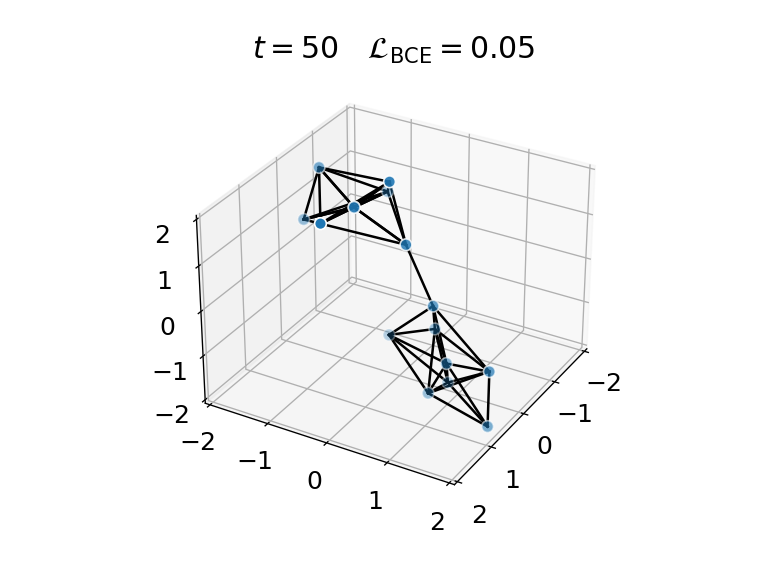

In [22]:
def animate(i):
    ax.clear()
    bce = model.decoder.bce(inter_coords[i], test_set[idx].edge_index, test_set[idx].neg_edge_index).item()
    title = '$t=%d \quad \mathcal{L}_{\mathsf{BCE}} = %.2f$' % (i, bce)
    plot_edge_index(test_set[idx].edge_index, coord=inter_coords[i], title=title, ax=ax, box_dim=2, show_grid=True, show_ax_values=True, transparent=False)

fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(projection='3d')
ani = animation.FuncAnimation(fig, animate, frames=range(len(inter_coords)), interval=500, repeat=False)
# ani.save('regenerate.gif', dpi=300, writer=animation.PillowWriter(fps=2))